In [1]:
# TODO
# Create function to get all edge IDs for a given Adm2 Unit

# Create function to extract deforestation data for edge
# - Add weighting option (distance-based from river)
# - Add river width-based weighting option
# - Allow choice between simple buffer and slope-based buffer

# Network model

In [1]:
import pickle
import warnings
import sqlite3
import shapely
from tqdm import tqdm
import numpy as np
import pandas as pd
import geopandas as gpd
from multiprocessing import Pool
from collections import defaultdict
import xarray as xr
import rioxarray as rxr
import os
import tempfile
from pysheds.grid import Grid
from rasterio.io import MemoryFile
import cv2
from itertools import chain, product
import pyproj
import sys
sys.path.append("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/code")
from data.preprocess.river_network import river_network, calculate_distance_from_estuary
from data.preprocess.drainage_polygons.extract_detailed_drainage_polygons import extract_polygons_grid_cell
from data.preprocess.drainage_polygons.aux_functions import expand_bounds, load_height_profile

# connect to database
conn = sqlite3.connect('/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/imagery/imagery.db')
# get grid data
grid_data = pd.read_sql_query("SELECT * FROM GridCells WHERE Internal=1", conn)
# get grid geometries
grid_geoms = gpd.read_feather("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/imagery/grid_cells.feather")
# merge data
grid_data = gpd.GeoDataFrame(grid_data.merge(grid_geoms, on = "CellID"))
# close connection
conn.close()

i = 525

rivers = gpd.read_feather("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/river_network/msc_rivers.feather").to_crs(5641)
rivers_subset = gpd.clip(rivers, grid_data.geometry.iloc[i])

boundaries = gpd.read_file("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/misc/raw/gadm/gadm41_BRA_2.json", engine = "pyogrio").to_crs(5641)
boundaries_subset = gpd.clip(boundaries, grid_data.geometry.iloc[i])

---

In [6]:
rivers_brazil = pickle.load(open("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/river_network/network.pkl", "rb"))
rivers_brazil_shapefile = gpd.read_feather("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/river_network/shapefile.feather")
rivers_brazil_topology = gpd.read_feather("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/river_network/topology.feather")

---

In [15]:
rivers_brazil_shapefile = calculate_distance_from_estuary(rivers_brazil_shapefile, rivers_brazil_topology)

---

In [5]:
# # create shapely polygons on a grid, spanning the entire planet with a resolution of 1 degrees
# grid = gpd.GeoDataFrame(geometry = [shapely.geometry.box(i, j, i+1, j+1) for i in range(-180, 180, 1) for j in range(-90, 90, 1)])
# boundaries_limits = gpd.read_file("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/misc/gadm_410-BRA.geojson", engine="pyogrio").to_crs(5641).buffer(200 * 1e3).to_crs(4326)
# grid["in_bbox"] = grid.intersects(shapely.geometry.box(*boundaries_limits.total_bounds))
# grid["in_boundaries"] = grid.intersects(boundaries_limits.geometry.iloc[0])grid_filtered = grid.copy()[grid.in_bbox]
# grid_filtered = grid_filtered[grid_filtered.centroid.map(lambda x: x.coords[0][0]) < -32.5]
# grid_filtered["formatted_lon"] = grid_filtered.bounds.minx.map(lambda x: "W" + str(int(x*-1)).zfill(3) if x < 0 else "E" + str(int(x)).zfill(3))
# grid_filtered["formatted_lat"] = grid_filtered.bounds.miny.map(lambda x: "S" + str(int(x*-1)).zfill(2) if x < 0 else "N" + str(int(x)).zfill(2))
# grid_filtered["filename"] = grid_filtered.apply(lambda x: f"/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/misc/raw/DEM_GLO-90/Copernicus_DSM_30_{x.formatted_lat}_00_{x.formatted_lon}_00/DEM/Copernicus_DSM_30_{x.formatted_lat}_00_{x.formatted_lon}_00_DEM.tif", axis = 1)

In [24]:
# filedir_dem_cop = "/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/misc/raw/DEM_GLO-90/"
# files_dem_cop = pd.Series(os.listdir(filedir_dem_cop))
# files_dem_cop = files_dem_cop[~files_dem_cop.str.contains(r"\.tar$")]
# files_dem_cop = files_dem_cop.map(lambda x: f"{filedir_dem_cop}{x}/DEM/{x}_DEM.tif")

In [25]:
# mfdataset = [rxr.open_rasterio(file, chunks = True)[0,:-1,:-1] for file in files_dem_cop] #grid_filtered[grid_filtered.in_boundaries]["filename"]
# height_profile = xr.combine_by_coords(mfdataset)

---

## Plots

---

In [8]:
# spatial join to associate river network with drainage areas
# split where multiple rivers in one polygon
# dissolve by river

# - Opt A: Simple polygons (closest point)
# for each query point, find closest point on exterior of drainage area
# at end node, take residual part of drainage area
# use pysheds to generate weighting matrix

# - Opt B: Complex polygons (exact watershed)
# compute weighting matrices to find best fit sink point for each query point
# compute exact watershed for each query point within the drainage area

In [9]:
from data.preprocess.drainage_areas import expand_bounds

In [10]:
drainage_polygons = gpd.read_feather("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/drainage_area.feather")
drainage_polygons_projected = drainage_polygons.to_crs(5641)
drainage_polygons_gridded = grid_data.sjoin(gpd.GeoDataFrame(geometry = drainage_polygons_projected.centroid, index = drainage_polygons_projected.index), how = "right").dropna(subset = ["index_left"])

In [11]:
with open("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/river_network/temp_update_set.pkl", "rb") as f:
    update_set = pickle.load(f)

In [12]:
# there was a bug in the script for the 10hr run of the fix
# if there was no polygon to fix in a given grid cell, the script returned None
# this bug is now fixed for future re-runs; I impute these values here
for idx in [idx for idx, val in update_set.items() if val is None]:
    update_set[idx] = drainage_polygons.loc[drainage_polygons_gridded.index[drainage_polygons_gridded.index_left == idx].values].to_crs(5641)

In [ ]:
# Combine update set
drainage_polygons = pd.concat(update_set).reset_index(drop = True)

# Join the polygons with the river network
joined = drainage_polygons.sjoin(rivers_brazil_shapefile, how="left", predicate = "intersects")
# Remove polygons with no corresponding river
joined.dropna(subset = ["index_right0", "index_right1", "index_right2"], inplace = True)
# Create a tuple of river indices
joined["index_right"] = joined.apply(lambda x: tuple([int(x.index_right0), int(x.index_right1), int(x.index_right2)]), axis = 1)
# Calculate the intersection length
joined["intersection_length"] = joined.apply(lambda x: x.geometry.intersection(rivers_brazil_shapefile.loc[x.index_right].geometry).length, axis = 1)
# Assign drainage polygons to rivers with longest intersection
joined_assignment = joined[["estuary", "river"]].iloc[joined.reset_index().groupby("index").intersection_length.idxmax()]

# Join in the assignment and dissolve by river
drainage_polygons = drainage_polygons.join(joined_assignment).to_crs(4326)
drainage_polygons["geometry"] = drainage_polygons.geometry.buffer(0)
drainage_polygons_dissolved = drainage_polygons.dissolve(["estuary", "river"]).reset_index()

In [14]:
# drainage_area_new = pd.concat([drainage_polygons_projected.drop(index = indices_to_remove), pd.concat(update_set).reset_index(drop = True)], ignore_index=True)
drainage_area_new = pd.concat(update_set).reset_index(drop = True)

In [15]:
# import matplotlib.pyplot as plt
# fig, ax = plt.subplots(figsize=(8,6))
# test.to_crs(4326).plot(ax = ax, color = "none", edgecolor = "black")
# update_set.plot(ax = ax, color = "none", edgecolor = "red")
# joined.to_crs(4326).plot(ax = ax, color = "green", alpha = .25)

---

In [17]:
with open("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/code/experiments/drainage_polygons_dissolved.pkl", "rb") as f:
    drainage_polygons_dissolved = pickle.load(f)

In [54]:
drainage_polygons_dissolved.to_feather("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/drainage/drainage_polygons_dissolved.feather")

In [18]:
def load_height_profile(bbox):
    """
    Load and return the height profile for a given bounding box.

    Args:
    bbox (tuple): A tuple representing the bounding box with four values (min latitude, min longitude, max latitude, max longitude).

    Returns:
    xarray.DataArray: An array containing the height profile within the specified bounding box.
    """

    # Generate file path suffixes for latitude and longitude using grid conventions
    # Latitudes and longitudes are formatted based on their hemisphere and rounded to the nearest degree
    lat_lon = product(
        [f"E{int(lat):03}" if lat >= 0 else f"W{-int(lat):03}" for lat in np.arange(np.floor(bbox[0]), np.ceil(bbox[2]), 1)],
        [f"N{int(lon):02}" if lon >= 0 else f"S{-int(lon):02}" for lon in np.arange(np.floor(bbox[1]), np.ceil(bbox[3]), 1)]
    )

    # Construct file paths for DEM (Digital Elevation Model) tiles within the bounding box
    files_dem_cop = [
        f"/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/misc/raw/DEM_GLO-90/Copernicus_DSM_30_{lon}_00_{lat}_00/DEM/Copernicus_DSM_30_{lon}_00_{lat}_00_DEM.tif"
        for lat, lon in lat_lon
    ]

    # Load the DEM files and combine them into a single DataArray using xarray, keeping the first channel and excluding the last pixel on each edge
    height_profile = xr.combine_by_coords([
        rxr.open_rasterio(file)[0, :-1, :-1] for file in files_dem_cop
    ])

    # Clip the combined height profile to exactly match the bounding box using rioxarray
    height_profile = height_profile.rio.clip_box(*bbox)

    return height_profile

def get_sub_polygon(query_points, c_polygon_projected, c_polygon_halves, c_polygon_halves_projected = None, mode="inner", detail = "approximate", direction="<-"):
    """
    Calculate a sub-polygon based on provided query points and a composite polygon.
    
    Args:
    query_points (list): Points that define the query polygon or segment.
    c_polygon_projected (shapely.Polygon): The main polygon on which operations are to be performed.
    c_polygon_halves (list): Exterior of the main polygon split into two halves at river.
    mode (str, optional): Mode of operation, either 'inner' or 'edge'. Defaults to 'inner'.
    direction (str, optional): Direction for processing in 'edge' mode, either '<-' or '->'. Defaults to '<-'.
    
    Returns:
    shapely.Polygon: A sub-polygon derived based on the mode.
    """
    # Function to extend a line segment slightly at both ends
    def get_extended_line(points):
        extended_line = shapely.LineString(
            np.vstack([
                (np.array(points[0]) + 0.5 * (np.array(points[0]) - np.array(points[1]))),
                np.array(points[1]),
                (np.array(points[2]) + 0.5 * (np.array(points[2]) - np.array(points[1])))
            ])
        )
        return extended_line
            
    if mode == "inner":
        # Find the nearest points on the polygon halves to the first and last query points
        t_closest_points_on_drainage_limit = [
            shapely.ops.nearest_points(shapely.Point(query_points[0]), c_polygon_halves)[1],
            shapely.ops.nearest_points(shapely.Point(query_points[-1]), c_polygon_halves)[1]
        ]
        
        if detail == "approximate":
            # Create a polygon using the start and end query points and their corresponding closest points
            t_sub_polygon = shapely.Polygon([
                query_points[0], 
                t_closest_points_on_drainage_limit[0][0], 
                t_closest_points_on_drainage_limit[1][0],
                query_points[-1], 
                t_closest_points_on_drainage_limit[1][1], 
                t_closest_points_on_drainage_limit[0][1]
            ])
            
        elif detail == "exact":
            def cut(line, line_coords_projected, points):
                # Cuts a line in two at a distance from its starting point
                coords = np.array(line.coords)
                
                c_query_points_projected = [line.project(points[0]), line.project(points[1])]
                
                t_points_matches = [np.argmin(np.abs(line_coords_projected - x)) for x in c_query_points_projected]
                
                if c_query_points_projected[0] == c_query_points_projected[1]:
                    return shapely.Point(coords[t_points_matches[0]])
                if c_query_points_projected[0] < c_query_points_projected[1]:
                    return shapely.LineString(coords[t_points_matches[0]:t_points_matches[1]+1])
                if c_query_points_projected[0] > c_query_points_projected[1]:
                    return shapely.LineString(coords[t_points_matches[0]:t_points_matches[1]-1:-1])
                
            # Create a polygon using the start and end query points and their corresponding closest points
            t_sub_polygon = shapely.Polygon(
                [query_points[0]] +\
                    list(cut(c_polygon_halves[0], c_polygon_halves_projected[0], [t_closest_points_on_drainage_limit[0][0], t_closest_points_on_drainage_limit[1][0]]).coords) +\
                    [query_points[1]] +\
                    list(cut(c_polygon_halves[1], c_polygon_halves_projected[1], [t_closest_points_on_drainage_limit[1][1], t_closest_points_on_drainage_limit[0][1]]).coords)
            )
            
    elif mode == "edge":
        # Reverse the order of query points if direction is '->'
        if direction == "->":
            query_points = list(reversed(query_points))
        
        # Find the closest point on the polygon halves to the second query point
        t_closest_points_on_drainage_limit = shapely.ops.nearest_points(shapely.Point(query_points[1]), c_polygon_halves)[1]
        
        # Split the projected polygon with the extended line and select sub-polygons
        t_polygons_to_test = list(shapely.ops.split(c_polygon_projected, get_extended_line([t_closest_points_on_drainage_limit[0].coords, query_points[1], t_closest_points_on_drainage_limit[1].coords])).geoms)
        
        # Identify which sub-polygon contains the query edge, selecting the one with the greatest intersection length
        t_max_polygon = np.argmax([shapely.LineString(query_points).intersection(x).length for x in t_polygons_to_test])
        t_sub_polygon = t_polygons_to_test[t_max_polygon]
    
    return t_sub_polygon

def edge_fix(query_points, c_split_polygon, c_polygon_half):
    """
    Modifies a polygon half to ensure that the closest points on it to a set of query points are more than 1 unit apart.
    
    Args:
    query_points (list): A list of tuples or lists representing x, y coordinates of points.
    c_polygon_half (shapely.geometry): A shapely LineString representing one half of a polygon.
    
    Returns:
    shapely.geometry.LineString: A modified LineString where the nearest points are more than 1 unit apart.
    """
    
    t_polygon_half = c_polygon_half

    # Snap the query points to the polygon half
    query_points = [shapely.geometry.Point(x) for x in query_points]#shapely.snap([shapely.geometry.Point(x) for x in query_points], t_polygon_half, tolerance = 5)

    # Find the points on the polygon half that are nearest to each query point
    t_nearest_points = shapely.snap(shapely.ops.nearest_points(query_points, t_polygon_half)[1], t_polygon_half, tolerance = 5)

    # Determine the direction for iteration based on the location of the nearest point
    t_direction = t_polygon_half.line_locate_point(t_nearest_points[0], normalized=True) < 0.1

    # Create a test line for checking the distance between the nearest points
    t_test_lines = [shapely.LineString([t_nearest_points[0], query_points[0]]),
                    shapely.LineString([t_nearest_points[1], query_points[1]])]

    # Iterate until the outward lines do not cross the opposite polygon or the polygon half is shorter than 200 units
    while not ((t_test_lines[0].intersection(c_split_polygon).length < 1) and (t_test_lines[1].intersection(c_split_polygon).length < 1)) and\
            (t_polygon_half.length > 200): 
        # Shorten the line by cutting off 1000 meters from the direction determined earlier
        if t_direction:
            t_polygon_half = shapely.ops.split(t_polygon_half, shapely.ops.snap(t_polygon_half.interpolate(1000), t_polygon_half, tolerance=5)).geoms[1]
        else:
            t_polygon_half = shapely.ops.split(t_polygon_half, shapely.ops.snap(t_polygon_half.interpolate(-1000), t_polygon_half, tolerance=5)).geoms[0]
        # Recalculate the nearest points after modification
        t_nearest_points = shapely.snap(shapely.ops.nearest_points([shapely.geometry.Point(x) for x in query_points], t_polygon_half)[1], t_polygon_half, tolerance = 5)
        # Update the test lines
        t_test_lines = [shapely.LineString([t_nearest_points[0], shapely.Point(query_points[0])]),
                        shapely.LineString([t_nearest_points[1], shapely.Point(query_points[1])])]
    
    return t_polygon_half

def compute_polygons_edge_pv(c_edge, payload, c_river, c_polygon_projected, c_polygon_halves, c_polygon_halves_projected, to_snap_points, to_snap_points_projected, mode, direction):
    """
    Computes a list of sub-polygons along the edge of a main polygon based on specified points and mode/direction.
    This function uses a primitive approach to compute sub-polygons based on the provided parameters, constructing
    the sub-polygons by connecting the query points with the nearest points on the polygon exterior.
    
    Args:
    c_edge: Edge data (not directly used in the function but may be intended for logging or later processing).
    payload: Additional data associated with the operation (not directly used in the function).
    c_river: River geometry data (not directly used in the function).
    c_polygon_projected (shapely.geometry): The main polygon that is projected in some coordinate system.
    c_polygon_halves (shapely.geometry): The halves of the main polygon used for precise sub-polygon calculations.
    to_snap_points (list): Original points to snap to the polygon edges (not used in computation within this function).
    to_snap_points_projected (list of shapely.Point): Points projected on the polygon edges used to compute sub-polygons.
    mode (str): Operational mode that determines how sub-polygons are computed, 'edge' or other modes.
    direction (str): Direction of computation along the polygon, supports '->' or '<-' indicating forward or reverse.

    Returns:
    list of shapely.Polygon: List of sub-polygons computed based on provided parameters.
    """

    polygons_pv = []  # List to hold the computed sub-polygons
    indices_not_null = np.array([i for i in range(len(to_snap_points_projected)) if to_snap_points_projected[i] is not None])

    # Iterate over all points to compute sub-polygons
    if all([x is None for x in to_snap_points_projected]):
        return [None] * len(to_snap_points_projected)
    i = 0
    while i < len(to_snap_points_projected) - 1:
        # 
        if i < min(indices_not_null) or i > max(indices_not_null):
            polygons_pv += [None]
            i += 1
            continue
        # Handle the first pair of points if mode is 'edge'
        if mode == "edge" and "<-" in direction and i == min(indices_not_null):
            # Get the sub-polygon for the first two points in reverse direction
            polygons_pv += [get_sub_polygon([to_snap_points_projected[indices_not_null[0]].coords[0], to_snap_points_projected[indices_not_null[1]].coords[0]], c_polygon_projected, c_polygon_halves, c_polygon_halves_projected, mode="edge", detail = "exact", direction="<-")]
            i = indices_not_null[1]
            continue
        # Handle the last pair of points if mode is 'edge'
        if mode == "edge" and "->" in direction and i == max(indices_not_null[:-1]):
            polygons_pv += [get_sub_polygon([to_snap_points_projected[indices_not_null[-2]].coords[0], to_snap_points_projected[indices_not_null[-1]].coords[0]], c_polygon_projected, c_polygon_halves, c_polygon_halves_projected, mode="edge", detail = "exact", direction="->")]
            polygons_pv += [None] * (len(to_snap_points_projected) - i - 1)
            break
        #
        if to_snap_points_projected[i + 1] is None:
            i_next = np.min(indices_not_null[indices_not_null > (i + 1)])
            polygons_pv += [get_sub_polygon([to_snap_points_projected[i].coords[0], to_snap_points_projected[i_next].coords[0]], c_polygon_projected, c_polygon_halves, c_polygon_halves_projected, mode="inner", detail = "exact", direction=direction)]
            polygons_pv += [None] * (i_next - i - 1)
            i = i_next
            continue
        # Compute sub-polygons for all other points
        else:
            polygons_pv += [get_sub_polygon([to_snap_points_projected[i].coords[0], to_snap_points_projected[i+1].coords[0]], c_polygon_projected, c_polygon_halves, c_polygon_halves_projected, mode="inner", detail = "exact", direction=direction)]
            i += 1
    
    for i in range(len(polygons_pv)):
        if polygons_pv[i] is not None:
            cumulative_polygons_pv = shapely.ops.unary_union([x for x in polygons_pv[:i] if x is not None])
            polygons_pv[i] = polygons_pv[i].buffer(0).difference(cumulative_polygons_pv)
    
    return polygons_pv

def compute_polygons_edge_da(c_edge, upstream_polygon, payload, c_polygon_projected, c_polygon_halves, to_snap_points, to_snap_points_projected):
    """
    Computes drainage area polygons for river segments that intersect with provided points,
    refining each polygon through several hydrological processing steps and snapping to the river network.
    
    Args:
    c_edge: Edge data (not directly used but possibly for later extension or analysis).
    upstream_polygon: Pre-computed polygon representing upstream limits.
    payload: Data container which may include GIS data necessary for the operation.
    c_polygon_projected (shapely.geometry): The projected polygon in which operations are confined.
    c_polygon_halves (shapely.geometry): The two halves of the projected polygon.
    to_snap_points (list): List of points before projection.
    to_snap_points_projected (list): List of shapely Points after projection.
    
    Returns:
    list: A list of polygons representing the drainage areas refined and snapped to actual river paths.
    """
    
    # Initial approximation of the edge bounding box polygon
    t_sub_polygon = get_sub_polygon([c_edge.geometry.coords[0], c_edge.geometry.coords[-1]], c_polygon_projected, c_polygon_halves)
    
    # Set up an in-memory file to save the height profile as a raster for pysheds processing
    with tempfile.NamedTemporaryFile() as memfile:
        # Load and preprocess height profile within the bounding box of the sub-polygon, expanded by 1.5 units
        t_height_profile = load_height_profile(expand_bounds(gpd.GeoSeries([t_sub_polygon.envelope], crs=5641).to_crs(4326).total_bounds, 1.5))
        # Fill missing values, set no data value, and save as raster
        t_height_profile.fillna(t_height_profile.max()).rio.write_nodata(-32767).rio.to_raster(memfile.name, driver="GTiff")
        # Load this raster into a pysheds grid
        c_grid = Grid.from_raster(memfile.name)
        c_dem = c_grid.read_raster(memfile.name)
    
    # Hydrological processing to refine the DEM for accurate flow direction and accumulation computation
    t_pit_filled_dem = c_grid.fill_pits(c_dem)  # Fill pits
    t_flooded_dem = c_grid.fill_depressions(t_pit_filled_dem)  # Fill depressions
    t_inflated_dem = c_grid.resolve_flats(t_flooded_dem)  # Resolve flat areas
    t_fdir = c_grid.flowdir(t_inflated_dem, dirmap=(64, 128, 1, 2, 4, 8, 16, 32))  # Compute flow direction
    c_acc = c_grid.accumulation(t_fdir, dirmap=(64, 128, 1, 2, 4, 8, 16, 32))  # Compute flow accumulation
    
    # Extract river networks and clip them to the payload geometry, dissolve and explode for unique segments
    t_extracted_river_network = c_grid.extract_river_network(t_fdir, c_acc > 500, dirmap=(64, 128, 1, 2, 4, 8, 16, 32))["features"]
    if t_extracted_river_network == []:
        t_extracted_river_network = c_grid.extract_river_network(t_fdir, c_acc > 100, dirmap=(64, 128, 1, 2, 4, 8, 16, 32))["features"]
    extracted_river_network = gpd.GeoDataFrame(t_extracted_river_network, crs=4326)
    candidate_rivers = gpd.clip(extracted_river_network, payload.geometry).dissolve().explode(index_parts=True).reset_index()
    
    # Nested function to extract drainage area polygons given a river point
    def get_polygon_da(point):
        # Generate a binary mask for the catchment area starting from the specified point using the computed flow direction
        mask = c_grid.catchment(x=point.x, y=point.y, fdir=t_fdir, dirmap=(64, 128, 1, 2, 4, 8, 16, 32), xytype='coordinate')

        # Find contours in the mask to delineate the boundaries of the catchment area
        polygon_image_space = cv2.findContours(np.array(mask).astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

        # Convert the image-space coordinates of the contour to geographic coordinates using the affine transformation of the grid
        polygon_affine_space = shapely.affinity.affine_transform(
            shapely.geometry.Polygon(polygon_image_space[0][0].squeeze()).buffer(0),  # Ensure valid geometry
            np.array(c_grid.affine)[[0,1,3,4,2,5]]  # Apply the grid's affine transformation
        )

        return polygon_affine_space

    # Function to find and snap appropriate drainage polygons to the river network based on proximity and containment
    def get_snapped_polygon_da(ii, threshold=0.9):
        # Find the nearest points on the extracted river segments to a given projected point
        c_nearest_points = [shapely.ops.nearest_points(x, to_snap_points_projected[ii])[0] for x in candidate_rivers.to_crs(5641).geometry]

        # Project the nearest points from local CRS to geographic CRS
        t_nearest_points_projected = gpd.GeoSeries(c_nearest_points, crs=5641).to_crs(4326).values

        # Rank the nearest points by distance to the target projected point
        t_distance_ranks = np.argsort([x.distance(to_snap_points_projected[ii]) for x in c_nearest_points])

        # Iterate over the ranked points, extracting and evaluating drainage polygons
        for idx, iii in enumerate(t_distance_ranks):
            if idx == 20:  # Timeout after 20 attempts
                warnings.warn(f"Timeout reached for finding fitting snap point: cut #{ii}", category=Warning)
                return shapely.Polygon()  # Return an empty polygon if no suitable point found after 20 tries
            t_drainage_polygon = get_polygon_da(t_nearest_points_projected[iii])
            if np.mean(t_drainage_polygon.contains(to_snap_points[:ii])) > threshold:
                return t_drainage_polygon  # Return the polygon if it sufficiently contains the target points
            if idx == (len(t_distance_ranks) - 1):
                warnings.warn(f"No suitable snap point: cut #{ii}", category=Warning)
                return shapely.Polygon()  # Return an empty polygon if no suitable points are found

    # Iterate over all projected points to match and refine drainage polygons
    snapped_polygons = [get_snapped_polygon_da(ii, 0.8) if to_snap_points_projected[ii] is not None else None for ii in range(1, len(to_snap_points_projected))]
    # Intersect these polygons with the payload geometry
    snapped_polygons_in_bounds = [payload.geometry.intersection(x) if x is not None else None for x in snapped_polygons]
    # Subtract upstream polygons to isolate new drainage areas
    snapped_polygons_differenced = []
    snapped_polygons_in_bounds_not_none = [i for i in range(len(snapped_polygons_in_bounds)) if snapped_polygons_in_bounds[i] is not None]
    i = 0
    while i < len(snapped_polygons_in_bounds):
        if snapped_polygons_in_bounds[i] is None:
            snapped_polygons_differenced.append(None)
            i += 1
        elif i == min(snapped_polygons_in_bounds_not_none):
            snapped_polygons_differenced.append(snapped_polygons_in_bounds[i].difference(upstream_polygon))
            i += 1
        else:
            snapped_polygons_differenced.append(snapped_polygons_in_bounds[i].difference(shapely.union_all([upstream_polygon] + [x for x in snapped_polygons_differenced if x is not None])))
            i += 1
                
    return snapped_polygons_differenced

def compute_polygons_edge(i, upstream_polygon, indices_edges_at_edge, payload, c_river, c_polygon_projected, c_polygon_halves, c_polygon_halves_projected, to_snap_points, to_snap_points_projected):
    """
    Processes a specific edge of a river to compute two types of polygons: one primitive set (pv) and another related to drainage areas (da).
    
    Args:
    i (int): Index of the river segment being processed.
    upstream_polygon (shapely.geometry): Predefined polygon that represents the upstream area, used for processing.
    payload (object): Contains additional data needed for processing, can include various types of geospatial data.
    c_river (GeoDataFrame): Contains the river segments, each row represents a segment of the river.
    c_polygon_projected (shapely.geometry): The main projected polygon for reference.
    c_polygon_halves (shapely.geometry): Divides the main polygon into halves, likely used for more detailed processing.
    to_snap_points (list): Original geographical points to which the processing must be aligned or snapped.
    to_snap_points_projected (list of shapely.Point): Projected points derived from `to_snap_points`.

    Returns:
    tuple: Contains two lists of polygons.
    """
    # Select the current river edge based on index
    c_edge = c_river.iloc[i]
    
    # Default processing mode and direction
    mode = "inner"
    direction = "-"
    
    # Adjust mode and direction if processing the first or last segment of the river
    if i == indices_edges_at_edge[0]:
        mode = "edge"
        direction = "<" + direction  # Add '<' to indicate starting edge
    if i == indices_edges_at_edge[-1]:
        mode = "edge"
        direction += ">"  # Append '>' to indicate ending edge
    
    # Compute polygons related to projection or visibility based on the adjusted settings
    polygons_pv = compute_polygons_edge_pv(c_edge, payload, c_river, c_polygon_projected, c_polygon_halves, c_polygon_halves_projected, to_snap_points, to_snap_points_projected, mode, direction)
    
    # Compute polygons related to drainage areas
    polygons_da = compute_polygons_edge_da(c_edge, upstream_polygon, payload, c_polygon_projected, c_polygon_halves, to_snap_points, to_snap_points_projected)
    
    # Return both sets of computed polygons
    return polygons_pv, polygons_da

def compute_polygons_river(payload, rivers, drainage_polygons, cut_length=1000):
    """
    Analyzes river segments within a given polygon, computes projections and drainage areas,
    and adjusts river ends to ensure they align with the polygon boundaries.
    
    Args:
    payload (DataFrame): Contains necessary data like geometry, river info, and other specifics.
    rivers (GeoDataFrame): Contains river data across multiple segments.
    drainage_polygons (not used): Included for potential future use.
    cut_length (int): Length of each segment of the river for processing.
    
    Returns:
    tuple: Contains two GeoDataFrames, one for projection polygons and another for drainage areas.
    """
    # Project the payload polygon to a new coordinate reference system for processing
    c_polygon = payload.geometry
    c_polygon_projected = gpd.GeoSeries([c_polygon], crs=4326).to_crs(5641).values[0]
    # Filter river data based on the specified river and estuary and check intersections with the payload polygon
    c_river = rivers.query(f"river == {payload.river} & estuary == {payload.estuary}")
    # c_river = c_river[c_river.to_crs(4326).bounds.apply(lambda x: shapely.geometry.box(*x).intersection(c_polygon).area > 0, axis=1)]
    
    # Initialize snapping points
    to_snap_points_projected = []
    to_snap_points = []
    # Determine segments and snapping points based on river length and segment offset
    for i in range(c_river.shape[0]):
        c_cuts = int((c_river.iloc[i].geometry.length + c_river.iloc[i].segment_offset) // cut_length)
        if c_cuts == 0:
            to_snap = np.array([c_river.iloc[i].geometry.coords[0], c_river.iloc[i].geometry.coords[-1]])
        else:
            to_snap = np.concatenate([[c_river.iloc[i].geometry.coords[0]], [c_river.iloc[i].geometry.interpolate(cut_length * (ii + 1)).coords[0] for ii in range(c_cuts)], [c_river.iloc[i].geometry.coords[-1]]])
        to_snap_points_projected.append([shapely.Point(x) if shapely.Point(x).intersects(c_polygon_projected) else None for x in to_snap])
        to_snap_points.append(gpd.GeoSeries(to_snap_points_projected[-1], crs=5641).to_crs(4326))
    
    ## Calculate river halves
    # Convert river geometries to a MultiLineString and concatenate coordinates
    c_river_coerced = shapely.geometry.MultiLineString([x if isinstance(x, shapely.geometry.LineString) else list(x.geoms) for x in c_river.geometry.values])
    c_river_coords = np.concatenate([x.coords for x in c_river_coerced.geoms])
    
    # Adjust river endpoints to align with the polygon exterior if they are within
    t_ends_within = [shapely.Point(c_river_coords[0]).within(c_polygon_projected), shapely.Point(c_river_coords[-1]).within(c_polygon_projected)]
    if t_ends_within[0]:
        c_river_coords = np.concatenate([shapely.ops.nearest_points(shapely.Point(c_river_coords[0]), c_polygon_projected.exterior)[1].coords, c_river_coords])
    if t_ends_within[1]:
        c_river_coords = np.concatenate([c_river_coords + shapely.ops.nearest_points(shapely.Point(c_river_coords[-1]), c_polygon_projected.exterior)[1].coords])
        
    # Split the polygon using the adjusted river coordinates
    c_split_polygons = list(shapely.ops.split(c_polygon_projected, shapely.geometry.LineString(c_river_coords)).geoms)
    c_polygon_halves = [x.exterior.difference(shapely.geometry.LineString(c_river_coords)) for x in c_split_polygons]
    
    # Merge segments of the polygon half and segmentize it every 10 units to add more vertices
    c_polygon_halves = [shapely.line_merge(x).segmentize(10) for x in c_polygon_halves]
    
    # Apply edge fixes for the first and last river segments
    t_to_snap_points_projected_coerced = [x for x in chain(*to_snap_points_projected) if x is not None]
    c_polygon_halves = [edge_fix([t_to_snap_points_projected_coerced[0].coords[0], t_to_snap_points_projected_coerced[1].coords[0]], x, y) for x, y in zip(c_split_polygons[::-1], c_polygon_halves)]
    c_polygon_halves = [edge_fix([t_to_snap_points_projected_coerced[-2].coords[0], t_to_snap_points_projected_coerced[-1].coords[0]], x, y) for x, y in zip(c_split_polygons[::-1], c_polygon_halves)]
    c_polygon_halves_projected = [np.array([x.project(shapely.Point(y)) for y in x.coords]) for x in c_polygon_halves]
    
    # Get the indices of river segments where not all points are None
    idx_not_all_none = [i for i in range(len(to_snap_points)) if not to_snap_points[i].isna().all()]
    
    # Compute projection and drainage polygons for each segment
    t_polygons_pv, t_polygons_da = compute_polygons_edge(0, shapely.Polygon(), [min(idx_not_all_none), max(idx_not_all_none)], payload, c_river, c_polygon_projected, c_polygon_halves, c_polygon_halves_projected, to_snap_points[0], to_snap_points_projected[0])
    polygons_pv = [t_polygons_pv]; polygons_da = [t_polygons_da]
    for i in tqdm(range(1, c_river.shape[0])):
        t_polygons_pv, t_polygons_da = compute_polygons_edge(i, shapely.ops.unary_union(list(chain(*polygons_da[:i]))), [min(idx_not_all_none), max(idx_not_all_none)], payload, c_river, c_polygon_projected, c_polygon_halves, c_polygon_halves_projected, to_snap_points[i], to_snap_points_projected[i])
        polygons_pv += [t_polygons_pv]; polygons_da += [t_polygons_da]
    
    # Helper function to compile polygon data into GeoDataFrame format
    def helper(polygons, i):
        return gpd.GeoDataFrame({
            "estuary": c_river.estuary.iloc[i],
            "river": c_river.river.iloc[i],
            "segment": c_river.segment.iloc[i],
            "subsegment": c_river.subsegment.iloc[i],
            "distance_from_estuary": list(np.arange((c_river.distance_from_estuary.iloc[i] // 1000) * 1000 + 1000 * (len(polygons[i]) - 1), (c_river.distance_from_estuary.iloc[i] // 1000) * 1000, -1000)) + [c_river.distance_from_estuary.iloc[i]],
            "geometry": polygons[i]
        })
    
    # Aggregate all projection and drainage polygons into GeoDataFrames and convert to appropriate CRS
    polygons_pv = pd.concat([helper(polygons_pv, i) for i in range(c_river.shape[0])]).set_crs(5641).to_crs(4326)
    polygons_da = pd.concat([helper(polygons_da, i) for i in range(c_river.shape[0])])
    
    return polygons_pv, polygons_da

#test_pv, test_da = compute_polygons_river(drainage_polygons_dissolved.query("river==30886 & estuary==136").iloc[0], rivers_brazil_shapefile, drainage_area_new)
test_pv, test_da = compute_polygons_river(drainage_polygons_dissolved.iloc[2], rivers_brazil_shapefile, drainage_area_new)

KeyboardInterrupt: 

In [30]:
def load_height_profile(bbox):
    """
    Load and return the height profile for a given bounding box.

    Args:
    bbox (tuple): A tuple representing the bounding box with four values (min latitude, min longitude, max latitude, max longitude).

    Returns:
    xarray.DataArray: An array containing the height profile within the specified bounding box.
    """

    # Generate file path suffixes for latitude and longitude using grid conventions
    # Latitudes and longitudes are formatted based on their hemisphere and rounded to the nearest degree
    lat_lon = product(
        [f"E{int(lat):03}" if lat >= 0 else f"W{-int(lat):03}" for lat in np.arange(np.floor(bbox[0]), np.ceil(bbox[2]), 1)],
        [f"N{int(lon):02}" if lon >= 0 else f"S{-int(lon):02}" for lon in np.arange(np.floor(bbox[1]), np.ceil(bbox[3]), 1)]
    )

    # Construct file paths for DEM (Digital Elevation Model) tiles within the bounding box
    files_dem_cop = [
        f"/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/misc/raw/DEM_GLO-90/Copernicus_DSM_30_{lon}_00_{lat}_00/DEM/Copernicus_DSM_30_{lon}_00_{lat}_00_DEM.tif"
        for lat, lon in lat_lon
    ]

    # Load the DEM files and combine them into a single DataArray using xarray, keeping the first channel and excluding the last pixel on each edge
    height_profile = xr.combine_by_coords([
        rxr.open_rasterio(file)[0, :-1, :-1] for file in files_dem_cop
    ])

    # Clip the combined height profile to exactly match the bounding box using rioxarray
    #height_profile = height_profile.rio.clip_box(*bbox)

    return height_profile

def get_sub_polygon(query_points, c_polygon_halves):
    """
    Calculate a sub-polygon based on provided query points and a composite polygon.
    
    Args:
    query_points (list): Points that define the query polygon or segment.
    c_polygon_projected (shapely.Polygon): The main polygon on which operations are to be performed.
    c_polygon_halves (list): Exterior of the main polygon split into two halves at river.
    mode (str, optional): Mode of operation, either 'inner' or 'edge'. Defaults to 'inner'.
    direction (str, optional): Direction for processing in 'edge' mode, either '<-' or '->'. Defaults to '<-'.
    
    Returns:
    shapely.Polygon: A sub-polygon derived based on the mode.
    """
    # Function to extend a line segment slightly at both ends
    def get_extended_line(points):
        extended_line = shapely.LineString(
            np.vstack([
                (np.array(points[0]) + 0.5 * (np.array(points[0]) - np.array(points[1]))),
                np.array(points[1]),
                (np.array(points[2]) + 0.5 * (np.array(points[2]) - np.array(points[1])))
            ])
        )
        return extended_line
            
    
    # Find the nearest points on the polygon halves to the first and last query points
    t_closest_points_on_drainage_limit = [
        shapely.ops.nearest_points(shapely.Point(query_points[0]), c_polygon_halves)[1],
        shapely.ops.nearest_points(shapely.Point(query_points[-1]), c_polygon_halves)[1]
    ]
        
    # Create a polygon using the start and end query points and their corresponding closest points
    t_sub_polygon = shapely.Polygon([
        query_points[0], 
        t_closest_points_on_drainage_limit[0][0], 
        t_closest_points_on_drainage_limit[1][0],
        query_points[-1], 
        t_closest_points_on_drainage_limit[1][1], 
        t_closest_points_on_drainage_limit[0][1]
    ])
    
    return t_sub_polygon

def edge_fix(query_points, c_split_polygon, c_polygon_half):
    """
    Modifies a polygon half to ensure that the closest points on it to a set of query points are more than 1 unit apart.
    
    Args:
    query_points (list): A list of tuples or lists representing x, y coordinates of points.
    c_polygon_half (shapely.geometry): A shapely LineString representing one half of a polygon.
    
    Returns:
    shapely.geometry.LineString: A modified LineString where the nearest points are more than 1 unit apart.
    """
    
    t_polygon_half = c_polygon_half

    # Snap the query points to the polygon half
    query_points = [shapely.geometry.Point(x) for x in query_points]#shapely.snap([shapely.geometry.Point(x) for x in query_points], t_polygon_half, tolerance = 5)

    # Find the points on the polygon half that are nearest to each query point
    t_nearest_points = shapely.snap(shapely.ops.nearest_points(query_points, t_polygon_half)[1], t_polygon_half, tolerance = 5)

    # Determine the direction for iteration based on the location of the nearest point
    t_direction = t_polygon_half.line_locate_point(t_nearest_points[0], normalized=True) < 0.1

    # Create a test line for checking the distance between the nearest points
    t_test_lines = [shapely.LineString([t_nearest_points[0], query_points[0]]),
                    shapely.LineString([t_nearest_points[1], query_points[1]])]

    # Iterate until the outward lines do not cross the opposite polygon or the polygon half is shorter than 200 units
    while not ((t_test_lines[0].intersection(c_split_polygon).length < 1) and (t_test_lines[1].intersection(c_split_polygon).length < 1)) and\
            (t_polygon_half.length > 200): 
        # Shorten the line by cutting off 1000 meters from the direction determined earlier
        if t_direction:
            t_polygon_half = shapely.ops.split(t_polygon_half, shapely.ops.snap(t_polygon_half.interpolate(1000), t_polygon_half, tolerance=5)).geoms[1]
        else:
            t_polygon_half = shapely.ops.split(t_polygon_half, shapely.ops.snap(t_polygon_half.interpolate(-1000), t_polygon_half, tolerance=5)).geoms[0]
        # Recalculate the nearest points after modification
        t_nearest_points = shapely.snap(shapely.ops.nearest_points([shapely.geometry.Point(x) for x in query_points], t_polygon_half)[1], t_polygon_half, tolerance = 5)
        # Update the test lines
        t_test_lines = [shapely.LineString([t_nearest_points[0], shapely.Point(query_points[0])]),
                        shapely.LineString([t_nearest_points[1], shapely.Point(query_points[1])])]
    
    return t_polygon_half


def compute_polygons_edge_da(c_edge, upstream_polygon, payload, c_polygon_projected, c_polygon_halves, to_snap_points, to_snap_points_projected):
    """
    Computes drainage area polygons for river segments that intersect with provided points,
    refining each polygon through several hydrological processing steps and snapping to the river network.
    
    Args:
    c_edge: Edge data (not directly used but possibly for later extension or analysis).
    upstream_polygon: Pre-computed polygon representing upstream limits.
    payload: Data container which may include GIS data necessary for the operation.
    c_polygon_projected (shapely.geometry): The projected polygon in which operations are confined.
    c_polygon_halves (shapely.geometry): The two halves of the projected polygon.
    to_snap_points (list): List of points before projection.
    to_snap_points_projected (list): List of shapely Points after projection.
    
    Returns:
    list: A list of polygons representing the drainage areas refined and snapped to actual river paths.
    """
    
    # Initial approximation of the edge bounding box polygon
    t_sub_polygon = get_sub_polygon([c_edge.geometry.coords[0], c_edge.geometry.coords[-1]], c_polygon_halves)
    
    # Set up an in-memory file to save the height profile as a raster for pysheds processing
    with tempfile.NamedTemporaryFile() as memfile:
        # Load and preprocess height profile within the bounding box of the sub-polygon, expanded by 1.5 units
        t_height_profile = load_height_profile(gpd.GeoSeries([t_sub_polygon.envelope], crs=5641).to_crs(4326).total_bounds)
        # Fill missing values, set no data value, and save as raster
        t_height_profile.fillna(t_height_profile.max()).rio.write_nodata(-32767).rio.to_raster(memfile.name, driver="GTiff")
        # Load this raster into a pysheds grid
        c_grid = Grid.from_raster(memfile.name)
        c_dem = c_grid.read_raster(memfile.name)
    
    # Hydrological processing to refine the DEM for accurate flow direction and accumulation computation
    t_pit_filled_dem = c_grid.fill_pits(c_dem)  # Fill pits
    t_flooded_dem = c_grid.fill_depressions(t_pit_filled_dem)  # Fill depressions
    t_inflated_dem = c_grid.resolve_flats(t_flooded_dem)  # Resolve flat areas
    t_fdir = c_grid.flowdir(t_inflated_dem, dirmap=(64, 128, 1, 2, 4, 8, 16, 32))  # Compute flow direction
    c_acc = c_grid.accumulation(t_fdir, dirmap=(64, 128, 1, 2, 4, 8, 16, 32))  # Compute flow accumulation
    
    # Extract river networks and clip them to the payload geometry, dissolve and explode for unique segments
    t_extracted_river_network = c_grid.extract_river_network(t_fdir, c_acc > 500, dirmap=(64, 128, 1, 2, 4, 8, 16, 32))["features"]
    if t_extracted_river_network == []:
        t_extracted_river_network = c_grid.extract_river_network(t_fdir, c_acc > 100, dirmap=(64, 128, 1, 2, 4, 8, 16, 32))["features"]
    if t_extracted_river_network == []:
        return [shapely.Polygon()] * (len(to_snap_points_projected) - 1)
    extracted_river_network = gpd.GeoDataFrame(t_extracted_river_network, crs=4326)
    candidate_rivers = gpd.clip(extracted_river_network, expand_bounds(gpd.GeoSeries([t_sub_polygon.envelope], crs=5641).to_crs(4326).total_bounds, 1.5)).dissolve().explode(index_parts=True).reset_index()
    
    # Nested function to extract drainage area polygons given a river point
    def get_polygon_da(point):
        # Generate a binary mask for the catchment area starting from the specified point using the computed flow direction
        mask = c_grid.catchment(x=point.x, y=point.y, fdir=t_fdir, dirmap=(64, 128, 1, 2, 4, 8, 16, 32), xytype='coordinate')

        # Find contours in the mask to delineate the boundaries of the catchment area
        polygon_image_space = cv2.findContours(np.array(mask).astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)[0][0].squeeze()

        # Return an empty polygon if the contour has less than 4 points
        if polygon_image_space.shape[0] < 4:
            return shapely.Polygon()
        
        # Convert the image-space coordinates of the contour to geographic coordinates using the affine transformation of the grid
        polygon_affine_space = shapely.affinity.affine_transform(
            shapely.geometry.Polygon(polygon_image_space).buffer(0),  # Ensure valid geometry
            np.array(c_grid.affine)[[0,1,3,4,2,5]]  # Apply the grid's affine transformation
        )

        return polygon_affine_space

    # Function to find and snap appropriate drainage polygons to the river network based on proximity and containment
    def get_snapped_polygon_da(ii, threshold=0.9):
        # Find the nearest points on the extracted river segments to a given projected point
        c_nearest_points = [shapely.ops.nearest_points(x, to_snap_points_projected[ii])[0] for x in candidate_rivers.to_crs(5641).geometry]

        # Project the nearest points from local CRS to geographic CRS
        t_nearest_points_projected = gpd.GeoSeries(c_nearest_points, crs=5641).to_crs(4326).values

        # Rank the nearest points by distance to the target projected point
        t_distance_ranks = np.argsort([x.distance(to_snap_points_projected[ii]) for x in c_nearest_points])

        # Iterate over the ranked points, extracting and evaluating drainage polygons
        for idx, iii in enumerate(t_distance_ranks):
            if idx == 20:  # Timeout after 20 attempts
                #warnings.warn(f"Timeout reached for finding fitting snap point: cut #{ii}", category=Warning)
                return shapely.Polygon()  # Return an empty polygon if no suitable point found after 20 tries
            t_drainage_polygon = get_polygon_da(t_nearest_points_projected[iii])
            if np.mean(t_drainage_polygon.contains(to_snap_points[:ii])) > threshold:
                return t_drainage_polygon  # Return the polygon if it sufficiently contains the target points
            if idx == (len(t_distance_ranks) - 1):
                #warnings.warn(f"No suitable snap point: cut #{ii}", category=Warning)
                return shapely.Polygon()  # Return an empty polygon if no suitable points are found

    # Iterate over all projected points to match and refine drainage polygons
    snapped_polygons = [get_snapped_polygon_da(ii, 0.8) if to_snap_points_projected[ii] is not None else None for ii in range(1, len(to_snap_points_projected))]
    # Intersect these polygons with the payload geometry
    snapped_polygons_in_bounds = [payload.geometry.intersection(x) if x is not None else None for x in snapped_polygons]
    # Subtract upstream polygons to isolate new drainage areas
    snapped_polygons_differenced = []
    snapped_polygons_in_bounds_not_none = [i for i in range(len(snapped_polygons_in_bounds)) if snapped_polygons_in_bounds[i] is not None]
    i = 0
    while i < len(snapped_polygons_in_bounds):
        if snapped_polygons_in_bounds[i] is None:
            snapped_polygons_differenced.append(None)
            i += 1
        elif i == min(snapped_polygons_in_bounds_not_none):
            snapped_polygons_differenced.append(snapped_polygons_in_bounds[i].difference(upstream_polygon))
            i += 1
        else:
            snapped_polygons_differenced.append(snapped_polygons_in_bounds[i].difference(shapely.union_all([upstream_polygon] + [x for x in snapped_polygons_differenced if x is not None])))
            i += 1
                
    return snapped_polygons_differenced


def compute_polygons_river(payload, rivers, cut_length=1000):
    """
    Analyzes river segments within a given polygon, computes projections and drainage areas,
    and adjusts river ends to ensure they align with the polygon boundaries.
    
    Args:
    payload (DataFrame): Contains necessary data like geometry, river info, and other specifics.
    rivers (GeoDataFrame): Contains river data across multiple segments.
    cut_length (int): Length of each segment of the river for processing.
    
    Returns:
    tuple: Contains two GeoDataFrames, one for projection polygons and another for drainage areas.
    """
    # Project the payload polygon to a new coordinate reference system for processing
    c_polygon = payload.geometry
    c_polygon_projected = gpd.GeoSeries([c_polygon], crs=4326).to_crs(5641).values[0]
    # Filter river data based on the specified river and estuary and check intersections with the payload polygon
    c_river = rivers.query(f"river == {payload.river} & estuary == {payload.estuary}")
    # c_river = c_river[c_river.to_crs(4326).bounds.apply(lambda x: shapely.geometry.box(*x).intersection(c_polygon).area > 0, axis=1)]
    
    # Initialize snapping points
    to_snap_points_projected = []
    to_snap_points = []
    # Determine segments and snapping points based on river length and segment offset
    for i in range(c_river.shape[0]):
        c_cuts = int((c_river.iloc[i].geometry.length + c_river.iloc[i].segment_offset) // cut_length)
        if c_cuts == 0:
            to_snap = np.array([c_river.iloc[i].geometry.coords[0], c_river.iloc[i].geometry.coords[-1]])
        else:
            to_snap = np.concatenate([[c_river.iloc[i].geometry.coords[0]], [c_river.iloc[i].geometry.interpolate(cut_length * (ii + 1)).coords[0] for ii in range(c_cuts)], [c_river.iloc[i].geometry.coords[-1]]])
        to_snap_points_projected.append([shapely.Point(x) if shapely.Point(x).intersects(c_polygon_projected) else None for x in to_snap])
        to_snap_points.append(gpd.GeoSeries(to_snap_points_projected[-1], crs=5641).to_crs(4326))
    
    ## Calculate river halves
    # Convert river geometries to a MultiLineString and concatenate coordinates
    c_river_coerced = shapely.geometry.MultiLineString([x if isinstance(x, shapely.geometry.LineString) else list(x.geoms) for x in c_river.geometry.values])
    c_river_coords = np.concatenate([x.coords for x in c_river_coerced.geoms])
    
    # Adjust river endpoints to align with the polygon exterior if they are within
    t_ends_within = [shapely.Point(c_river_coords[0]).within(c_polygon_projected), shapely.Point(c_river_coords[-1]).within(c_polygon_projected)]
    if t_ends_within[0]:
        c_river_coords = np.concatenate([[1e9 * (c_river_coords[0] - c_river_coords[1]) + c_river_coords[0]], c_river_coords])
    if t_ends_within[1]:
        c_river_coords = np.concatenate([c_river_coords, [1e9  * (c_river_coords[-1] - c_river_coords[-2]) + c_river_coords[-1]]])
        
    # Split the polygon using the adjusted river coordinates
    c_split_polygons = list(shapely.ops.split(c_polygon_projected, shapely.geometry.LineString(c_river_coords)).geoms)
    c_polygon_halves = [x.exterior.difference(shapely.geometry.LineString(c_river_coords)) for x in c_split_polygons]
    
    # Merge segments of the polygon half and segmentize it every 10 units to add more vertices
    c_polygon_halves = [shapely.line_merge(x).segmentize(10) for x in c_polygon_halves]
    
    # Compute drainage polygons for each segment
    t_polygons_da = compute_polygons_edge_da(c_river.iloc[0], shapely.Polygon(), payload, c_polygon_projected, c_polygon_halves, to_snap_points[0], to_snap_points_projected[0])
    polygons_da = [t_polygons_da]
    for i in range(1, c_river.shape[0]):
        t_polygons_da = compute_polygons_edge_da(c_river.iloc[i], shapely.ops.unary_union(list(chain(*polygons_da[:i]))), payload, c_polygon_projected, c_polygon_halves, to_snap_points[i], to_snap_points_projected[i])
        polygons_da += [t_polygons_da]
    
    # Helper function to compile polygon data into GeoDataFrame format
    def helper(polygons, i):
        return gpd.GeoDataFrame({
            "estuary": c_river.estuary.iloc[i],
            "river": c_river.river.iloc[i],
            "segment": c_river.segment.iloc[i],
            "subsegment": c_river.subsegment.iloc[i],
            "distance_from_estuary": list(np.arange((c_river.distance_from_estuary.iloc[i] // 1000) * 1000 + 1000 * (len(polygons[i]) - 1), (c_river.distance_from_estuary.iloc[i] // 1000) * 1000, -1000)) + [c_river.distance_from_estuary.iloc[i]],
            "geometry": polygons[i]
        })
    
    # Aggregate all projection and drainage polygons into GeoDataFrames and convert to appropriate CRS
    polygons_da = pd.concat([helper(polygons_da, i) for i in range(c_river.shape[0])])
    
    if (polygons_da.is_empty | polygons_da.geometry.isna()).all():
        polygons_da.loc[polygons_da[~polygons_da.geometry.isna()]["distance_from_estuary"].idxmin(), "geometry"] = c_polygon
    
    return polygons_da

#test_pv, test_da = compute_polygons_river(drainage_polygons_dissolved.query("river==30886 & estuary==136").iloc[0], rivers_brazil_shapefile, drainage_area_new)
i = 10102
test_da = compute_polygons_river(drainage_polygons_dissolved.iloc[i], rivers_brazil_shapefile, drainage_area_new)

In [1]:
# Standard library imports
import os
import pickle
import sqlite3
import sys
from collections import defaultdict
from itertools import chain

# Third-party imports for data handling and computation
import geopandas as gpd
import numpy as np
import pandas as pd
import xarray as xr
import rioxarray as rxr
from tqdm import tqdm

# Geospatial and image processing libraries
import cv2
import shapely
from pysheds.grid import Grid
from rasterio.io import MemoryFile

# Multiprocessing imports
from multiprocessing import Pool

# Local module imports for specific functionality
sys.path.append("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/code")
from data.preprocess.river_network import river_network, calculate_distance_from_estuary
from data.preprocess.drainage_polygons.extract_detailed_drainage_polygons import extract_polygons_river, expand_bounds

# Database connection to fetch grid data
conn = sqlite3.connect('/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/imagery/imagery.db')
grid_data = pd.read_sql_query("SELECT * FROM GridCells WHERE Internal=1", conn)
grid_geoms = gpd.read_feather("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/imagery/grid_cells.feather")
grid_data = gpd.GeoDataFrame(grid_data.merge(grid_geoms, on="CellID"))
conn.close()

# Loading river network data and computing distances from the estuary
rivers_brazil = pickle.load(open("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/river_network/network.pkl", "rb"))
rivers_brazil_shapefile = gpd.read_feather("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/river_network/shapefile.feather")
rivers_brazil_topology = gpd.read_feather("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/river_network/topology.feather")
rivers_brazil_shapefile = calculate_distance_from_estuary(rivers_brazil_shapefile, rivers_brazil_topology)

# Get the dissolved drainage polygons
drainage_polygons_dissolved = gpd.read_feather("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/drainage/drainage_polygons_dissolved.feather")

# Create a iterable of chunks
chunksize = 100
chunks = [list(range(i, min(i + chunksize, len(drainage_polygons_dissolved)))) for i in range(0, len(drainage_polygons_dissolved), chunksize)]

In [3]:
9999 % 1000

999

In [52]:
len(drainage_polygons_dissolved) * 8.66 / 8 / 60 / 60

29.363113194444445

In [51]:
test_da = compute_polygons_river(drainage_polygons_dissolved.iloc[0], rivers_brazil_shapefile, drainage_area_new)

KeyboardInterrupt: 

In [41]:
def worker(i):
    try: 
        return compute_polygons_river(drainage_polygons_dissolved.iloc[i], rivers_brazil_shapefile, drainage_area_new)
    except:
        return None
with Pool(4) as p:
    results = list(tqdm(p.imap(worker, range(8), chunksize=1), total=10))

 80%|████████  | 8/10 [01:09<00:17,  8.66s/it]


In [42]:
with Pool(1) as p:
    results = list(tqdm(p.imap(worker, range(8), chunksize=1), total=10))

 80%|████████  | 8/10 [02:04<00:31, 15.60s/it]


In [43]:
results = list(tqdm(map(worker, range(8)), total=10))

 80%|████████  | 8/10 [01:57<00:29, 14.72s/it]


<Axes: >

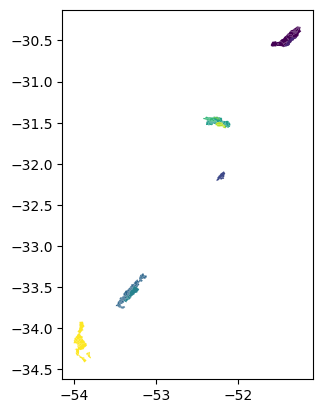

In [38]:
pd.concat({idx: val for idx, val in enumerate(results)}).reset_index().plot(column = "level_0")

TypeError: Cannot cast array data from dtype('float64') to dtype('int64') according to the rule 'safe'

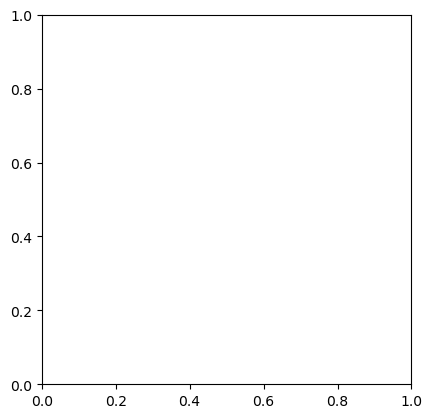

In [96]:
ax = test_da.sort_values("distance_from_estuary").plot(column = "distance_from_estuary", edgecolor = "black")
rivers_brazil_shapefile.query(f"estuary=={drainage_polygons_dissolved.iloc[i].estuary}&river=={drainage_polygons_dissolved.iloc[i].river}").to_crs(4326).plot(ax=ax, color="red")
drainage_polygons_dissolved.iloc[[i]].plot()

In [63]:
rivers_brazil_shapefile.query(f"estuary=={drainage_polygons_dissolved.iloc[i].estuary}&river=={drainage_polygons_dissolved.iloc[i].river}").to_crs(4326).plot(ax=ax, color="red")


<Axes: >

<Figure size 640x480 with 0 Axes>

<Axes: >

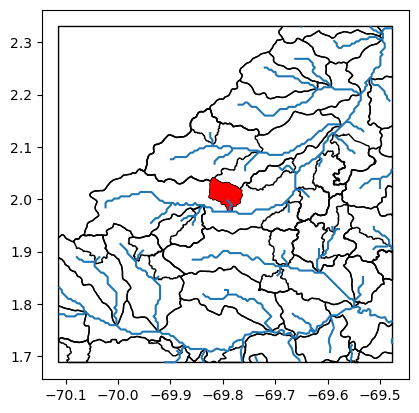

In [98]:
ax = gpd.clip(drainage_polygons_dissolved, expand_bounds(drainage_polygons_dissolved.iloc[[i]].total_bounds, 10)).plot(edgecolor = "black", color = "none")
drainage_polygons_dissolved.iloc[[i]].plot(ax=ax, color="red")
gpd.clip(rivers_brazil_shapefile, expand_bounds(drainage_polygons_dissolved.iloc[[i]].to_crs(5641).total_bounds, 10)).to_crs(4326).plot(ax=ax)

KeyboardInterrupt: 

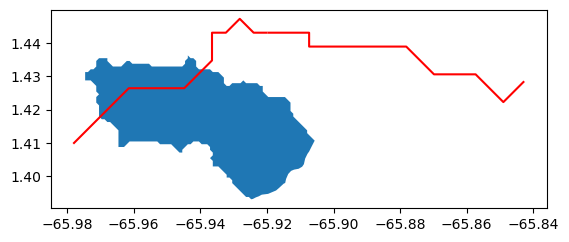

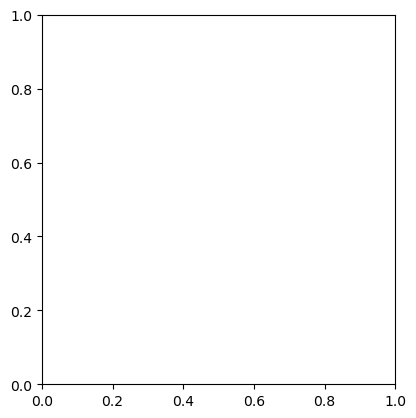

In [66]:
ax = rivers_brazil_shapefile.query(f"estuary=={drainage_polygons_dissolved.iloc[i].estuary}&river=={drainage_polygons_dissolved.iloc[i].river}").to_crs(4326).plot(color="red")
drainage_polygons_dissolved.iloc[[i]].plot(ax=ax)


In [30]:
candidate_rivers, extracted_river_network = pickle.load(open("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/code/experiments/test.pkl", "rb"))

<Axes: >

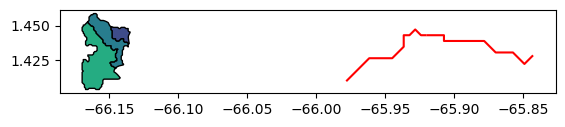

In [116]:
rivers_brazil_shapefile.query("estuary==136&river==419").to_crs(4326).plot(ax=ax, color ="red")

In [18]:
t_to_snap_points_projected_coerced, c_split_polygons, c_polygon_halves = pickle.load(open("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/code/experiments/test.pkl", "rb"))

In [19]:
query_points = [t_to_snap_points_projected_coerced[0].coords[0], t_to_snap_points_projected_coerced[1].coords[0]]
c_polygon_half = c_polygon_halves[0]
c_split_polygon = c_split_polygons[-1]

In [40]:
c_polygon_half.geoms

<Axes: >

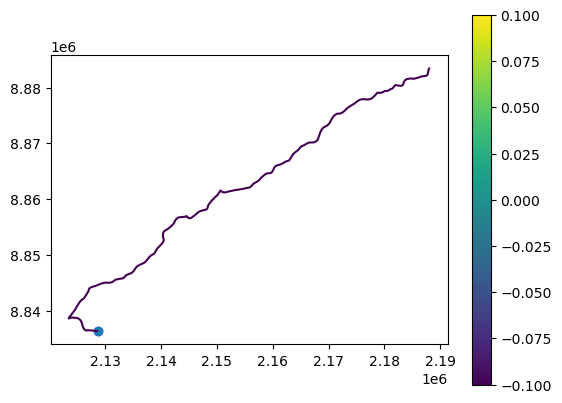

In [43]:
ax = gpd.GeoSeries(shapely.ops.split(t_polygon_half, shapely.snap(t_nearest_points[0], c_polygon_half, tolerance=100)).geoms).reset_index().plot(column = "index", legend = True)
gpd.GeoSeries(t_nearest_points).plot(ax=ax)

In [146]:
ax = gpd.GeoSeries(shapely.ops.split(shapely.ops.split(c_polygon_half, t_nearest_points[0]).geoms[1], t_nearest_points[1]).geoms[0])#.reset_index().plot(column="index")
gpd.GeoSeries(t_nearest_points).plot(ax=ax)

AttributeError: 'GeoSeries' object has no attribute 'set_aspect'

<Axes: >

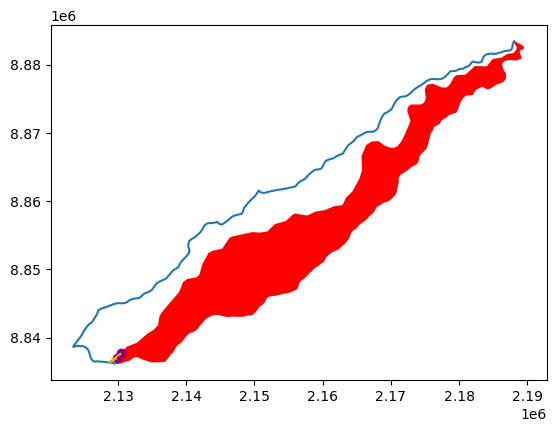

In [23]:
ax = gpd.GeoSeries([c_polygon_half]).plot()
gpd.GeoSeries([c_split_polygon]).plot(ax=ax, color = "red")
gpd.GeoSeries(query_points).plot(ax=ax, color="purple")
gpd.GeoSeries([shapely.LineString([t_nearest_points[0], shapely.Point(query_points[0])]),
               shapely.LineString([t_nearest_points[1], shapely.Point(query_points[1])])]).plot(ax=ax, color="orange")
#ax.set_xlim(2.185e6, 2.195e6); ax.set_ylim(8.875e6, 8.885e6)

In [32]:
compute_polygons_river(drainage_polygons_dissolved.iloc[0], rivers_brazil_shapefile, drainage_area_new)

KeyboardInterrupt: 

In [33]:
t_to_snap_points_projected_coerced, c_polygon_halves = pickle.load(open("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/code/experiments/test.pkl", "rb"))

In [37]:
edge_fix([t_to_snap_points_projected_coerced[0], t_to_snap_points_projected_coerced[1]], c_polygon_halves[0])

KeyboardInterrupt: 

<Axes: >

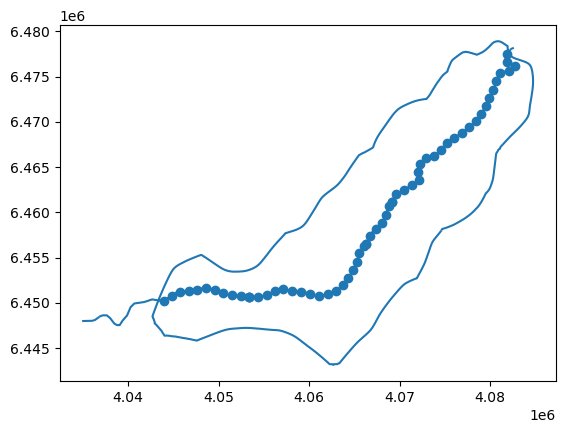

In [35]:
ax = gpd.GeoSeries(t_to_snap_points_projected_coerced + c_polygon_halves).plot()
rivers_brazil_shapefile.query("estuary==0&river==0").plot(ax=ax)

In [117]:
def load_height_profile(bbox):
    lat_lon = product([f"E{int(lat):03}" if lat >= 0 else f"W{-int(lat):03}" for lat in np.arange(np.floor(bbox[0]), np.ceil(bbox[2]), 1)],
                      [f"N{int(lon):02}" if lon >= 0 else f"S{-int(lon):02}" for lon in np.arange(np.floor(bbox[1]), np.ceil(bbox[3]), 1)])
    files_dem_cop = [f"/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/misc/raw/DEM_GLO-90/Copernicus_DSM_30_{lon}_00_{lat}_00/DEM/Copernicus_DSM_30_{lon}_00_{lat}_00_DEM.tif" for lat, lon in lat_lon]
    # load height profile
    height_profile = xr.combine_by_coords([rxr.open_rasterio(file, chunks = True)[0,:-1,:-1] for file in files_dem_cop])
    # clip height profile
    height_profile = height_profile.rio.clip_box(*bbox)
    return height_profile

def edge_fix(query_points, c_polygon_half):
    # merge and segmentize the polygon half
    t_polygon_half = shapely.line_merge(c_polygon_half).segmentize(10)
    # get the points on the polygon half closest to the query point
    t_nearest_points = shapely.ops.nearest_points([shapely.Point(x) for x in query_points], t_polygon_half)[1]
    # get the direction in which he iterate on the polygon half, cutting it bit by bit
    t_direction = t_polygon_half.line_locate_point(t_nearest_points[0], normalized = True) < .1
    # iterate until the distance between the two points is greater than 1
    while ((t_nearest_points[0].distance(t_nearest_points[1]) < 1) & (t_polygon_half.length > 200)):
        # shorten the line to by 1000 meters
        if t_direction:
            t_polygon_half = shapely.ops.split(t_polygon_half, shapely.snap(t_polygon_half.interpolate(1000), t_polygon_half, tolerance = 5)).geoms[1]
        else:
            t_polygon_half = shapely.ops.split(t_polygon_half, shapely.snap(t_polygon_half.interpolate(-1000), t_polygon_half, tolerance = 5)).geoms[0]
        # get the points on the polygon half closest to the query point
        t_nearest_points = shapely.ops.nearest_points([shapely.Point(x) for x in query_points], t_polygon_half)[1]
    return t_polygon_half

def get_sub_polygon(query_points, c_polygon_projected, c_polygon_halves, mode = "inner", direction = "<-"):
    if mode == "inner":
        t_closest_points_on_drainage_limit = [shapely.ops.nearest_points(shapely.Point(query_points[0]), c_polygon_halves)[1],
                                              shapely.ops.nearest_points(shapely.Point(query_points[-1]), c_polygon_halves)[1]]
        t_sub_polygon = shapely.Polygon([
            query_points[0], t_closest_points_on_drainage_limit[0][0], t_closest_points_on_drainage_limit[1][0],
            query_points[-1], t_closest_points_on_drainage_limit[1][1], t_closest_points_on_drainage_limit[0][1]
            ])
    elif mode == "edge":
        if direction == "->":
            query_points = list(reversed(query_points))
        # get the closest points on the drainage limit for the second point
        t_closest_points_on_drainage_limit = shapely.ops.nearest_points(shapely.Point(query_points[1]), c_polygon_halves)[1]
        # extend the line defined by points
        def get_extended_line(points):
            extended_line = shapely.LineString(
                np.vstack([
                    (np.array(points[0]) + 0.1 * (np.array(points[0]) - np.array(points[1]))),
                    np.array(points[1]),
                    (np.array(points[2]) + 0.1 * (np.array(points[2]) - np.array(points[1])))
                    ])
                )
            return extended_line
        # get the two potential sub-polygons by splitting
        t_polygons_to_test = list(shapely.ops.split(c_polygon_projected, get_extended_line([t_closest_points_on_drainage_limit[0].coords, query_points[1], t_closest_points_on_drainage_limit[1].coords])).geoms)
        # test which sub-polygon contains the query edge
        t_max_polygon = np.argmax([shapely.LineString(query_points).intersection(x).length for x in t_polygons_to_test])
        t_sub_polygon = t_polygons_to_test[t_max_polygon]
    return t_sub_polygon

def compute_polygons_edge_pv(c_edge, payload, c_river, c_polygon_projected, c_polygon_halves, to_snap_points, to_snap_points_projected, mode, direction):
    #pickle.dump([c_edge, payload, c_river, c_polygon_projected, c_polygon_halves, to_snap_points, to_snap_points_projected, mode, direction], open("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/code/experiments/test.pkl", "wb"))
    polygons_pv = []
    i_start = 0; i_end = len(to_snap_points_projected) - 1
    if mode == "edge" and "<-" in direction:
        i_start = 1 
        polygons_pv += [get_sub_polygon([to_snap_points_projected[0].coords[0], to_snap_points_projected[1].coords[0]], c_polygon_projected, c_polygon_halves, mode = "edge", direction = "<-")]
    if mode == "edge" and "->" in direction:
        i_end = len(to_snap_points_projected) - 2
    for i in range(i_start, i_end):
        polygons_pv += [get_sub_polygon([to_snap_points_projected[i].coords[0], to_snap_points_projected[i+1].coords[0]], c_polygon_projected, c_polygon_halves, mode = "inner", direction = direction)]
    if mode == "edge" and "->" in direction:
        polygons_pv += [get_sub_polygon([to_snap_points_projected[-2].coords[0], to_snap_points_projected[-1].coords[0]], c_polygon_projected, c_polygon_halves, mode = "edge", direction = "->")]
        
    return polygons_pv

def compute_polygons_edge_da(c_edge, upstream_polygon, payload, c_river, c_polygon_projected, c_polygon_halves, to_snap_points, to_snap_points_projected):
    # get sub polygon as rough approximation of edge bbox
    t_sub_polygon = get_sub_polygon([c_edge.geometry.coords[0], c_edge.geometry.coords[-1]], c_polygon_projected, c_polygon_halves)
    
    # get pysheds grid via memory file
    with tempfile.NamedTemporaryFile() as memfile:
        # load subset of height profile
        t_height_profile = load_height_profile(expand_bounds(gpd.GeoSeries([t_sub_polygon.envelope], crs=5641).to_crs(4326).total_bounds, 1.5))
        t_height_profile.fillna(t_height_profile.max()).rio.write_nodata(-32767).rio.to_raster(memfile.name, driver = "GTiff")
        c_grid = Grid.from_raster(memfile.name)
        c_dem = c_grid.read_raster(memfile.name)
        
    # define direction vectors
    dirmap = (64, 128, 1, 2, 4, 8, 16, 32)
    # get interval of height grid
    grid_interval = t_height_profile.coords["y"][1].values - t_height_profile.coords["y"][0].values
        
    # rivershed workflow @https://github.com/mdbartos/pysheds
    # fill pits
    t_pit_filled_dem = c_grid.fill_pits(c_dem)
    # fill depressions
    t_flooded_dem = c_grid.fill_depressions(t_pit_filled_dem)
    # resolve flats
    t_inflated_dem = c_grid.resolve_flats(t_flooded_dem)
    # compute flow direction
    t_fdir = c_grid.flowdir(t_inflated_dem, dirmap=dirmap)
    c_acc = c_grid.accumulation(t_fdir, dirmap=dirmap)
    # extract river networks
    extracted_river_network = gpd.GeoDataFrame(c_grid.extract_river_network(t_fdir, c_acc > 500, dirmap=dirmap)["features"], crs = 4326)
    # clip river network to polygon
    candidate_rivers = gpd.clip(extracted_river_network, payload.geometry).dissolve().explode(index_parts=True).reset_index()
    
    #
    def get_polygon_da(point):
        ## extract catchment polygons
        # get catchment areas
        mask = c_grid.catchment(x=point.x, y=point.y, fdir=t_fdir, dirmap=dirmap, xytype='coordinate')
        # get polygons in image space
        polygon_image_space = cv2.findContours(np.array(mask).astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
        # affine transform to geospatial coordinates
        polygon_affine_space = shapely.affinity.affine_transform(shapely.geometry.Polygon(polygon_image_space[0][0].squeeze()).buffer(0), np.array(c_grid.affine)[[0,1,3,4,2,5]])
        #
        return polygon_affine_space
    
    #
    def get_snapped_polygon_da(ii, threshold = .9):
        # get closest points on extracted river segments
        c_nearest_points = [shapely.ops.nearest_points(x, to_snap_points_projected[ii])[0] for x in candidate_rivers.to_crs(5641).geometry]
        # project
        t_nearest_points_projected = gpd.GeoSeries(c_nearest_points, crs=5641).to_crs(4326).values
        # get distance ranks
        t_distance_ranks = np.argsort([x.distance(to_snap_points_projected[ii]) for x in c_nearest_points])
        #
        iii = 0
        for idx in t_distance_ranks:
            if iii == 20:
                warnings.warn(f"Timeout reached for finding fitting snap point: cut #{ii}", category=Warning)
                return shapely.Polygon()
            t_drainage_polygon = get_polygon_da(t_nearest_points_projected[idx])
            if np.mean(t_drainage_polygon.contains(to_snap_points[:ii])) > threshold:
                return t_drainage_polygon #t_nearest_points_projected[idx]#
            if iii == (len(t_distance_ranks) - 1):
                warnings.warn(f"No suitable snap point: cut #{ii}", category=Warning)
                return shapely.Polygon()
            iii += 1
    
    # get drainage polygons from iterative matching of snapped points
    snapped_polygons = [get_snapped_polygon_da(ii, .8) for ii in range(1, len(to_snap_points_projected))]
    # get snapped polygons in bounds
    snapped_polygons_in_bounds = [payload.geometry.intersection(x) for x in snapped_polygons]
    # difference to get snapped polygons
    snapped_polygons_differenced = [snapped_polygons_in_bounds[0].difference(upstream_polygon)] + [snapped_polygons_in_bounds[i].difference(snapped_polygons_in_bounds[i-1]) for i in range(1, len(snapped_polygons_in_bounds))]
    
    return snapped_polygons_differenced

def compute_polygons_edge(i, upstream_polygon, payload, c_river, c_polygon_projected, c_polygon_halves, to_snap_points, to_snap_points_projected):
    c_edge = c_river.iloc[i]
    
    mode = "inner"; direction = "-"
    if i == 0:
        mode = "edge"; direction = "<" + direction
    if i == c_river.shape[0] - 1:
        mode = "edge"; direction += ">"
    
    polygons_pv = compute_polygons_edge_pv(c_edge, payload, c_river, c_polygon_projected, c_polygon_halves, to_snap_points, to_snap_points_projected, mode, direction)
    polygons_da = compute_polygons_edge_da(c_edge, upstream_polygon, payload, c_river, c_polygon_projected, c_polygon_halves, to_snap_points, to_snap_points_projected)
    
    return polygons_pv, polygons_da

def compute_polygons_river(payload, rivers, drainage_polygons, cut_length = 1000):
    # extract payload
    c_polygon = payload.geometry
    c_polygon_projected = gpd.GeoSeries([c_polygon], crs=4326).to_crs(5641).values[0]
    c_river = rivers.query(f"river == {payload.river} & estuary == {payload.estuary}")
    c_river = c_river[c_river.to_crs(4326).bounds.apply(lambda x: shapely.geometry.box(*x).intersection(c_polygon).area > 0, axis = 1)]
    
    # get all coordinates of the river
    c_river_coerced = shapely.geometry.MultiLineString(list(chain(*[[x] if isinstance(x, shapely.geometry.LineString) else list(x.geoms) for x in c_river.geometry.values])))
    c_river_coords = np.concatenate([x.coords for x in c_river_coerced.geoms])
    # check if the ends of the river are within the polygon
    t_ends_within = [shapely.Point(c_river_coords[0]).within(c_polygon_projected), shapely.Point(c_river_coords[-1]).within(c_polygon_projected)]
    # if not, add the closest point on the exterior of the polygon
    if t_ends_within[0]:
        c_river_coords = np.concatenate([shapely.ops.nearest_points(shapely.Point(c_river_coords[0]), c_polygon_projected.exterior)[1].coords, c_river_coords])
    if t_ends_within[1]:
        c_river_coords = np.concatenate([c_river_coords + shapely.ops.nearest_points(shapely.Point(c_river_coords[-1]), c_polygon_projected.exterior)[1].coords])
    # split the polygon by the river
    t_split_polygon = shapely.ops.split(c_polygon_projected, shapely.geometry.LineString(c_river_coords))
    # get the part of the exterior of the polygon that is not part of the river
    c_polygon_halves = [x.exterior.difference(shapely.geometry.LineString(c_river_coords)) for x in t_split_polygon.geoms]
    
    to_snap_points_projected = []
    to_snap_points = []
    ## determine segments
    for i in range(c_river.shape[0]):
        # get number of cuts
        c_cuts = int((c_river.iloc[i].geometry.length + c_river.iloc[i].segment_offset) // cut_length)
        # get points to snap
        if c_cuts == 0:
            to_snap = np.concatenate([np.array(c_river.iloc[i].geometry.coords[0]).reshape(1,-1), np.array(c_river.iloc[i].geometry.coords[-1]).reshape(1,-1)])
        else:
            to_snap = np.concatenate([np.array(c_river.iloc[i].geometry.coords[0]).reshape(1,-1), np.array([c_river.iloc[i].geometry.interpolate(cut_length * (ii + 1)).coords for ii in range(c_cuts)]).reshape(-1,2), np.array(c_river.iloc[i].geometry.coords[-1]).reshape(1,-1)])
        #
        to_snap_points_projected += [np.apply_along_axis(shapely.Point, 1, to_snap)]
        to_snap_points += [gpd.GeoSeries(to_snap_points_projected[-1], crs=5641).to_crs(4326).values]
    
    ## apply edge fix
    c_polygon_halves = [edge_fix([to_snap_points_projected[0][0], to_snap_points_projected[0][1]], x) for x in c_polygon_halves]
    c_polygon_halves = [edge_fix([to_snap_points_projected[-1][-2], to_snap_points_projected[-1][-1]], x) for x in c_polygon_halves]
    
    ## drainage-approximating polygons
    t_polygons_pv, t_polygons_da = compute_polygons_edge(0, shapely.Polygon(), payload, c_river, c_polygon_projected, c_polygon_halves, to_snap_points[0], to_snap_points_projected[0])
    polygons_pv = [t_polygons_pv]; polygons_da = [t_polygons_da]
    for i in tqdm(range(1, c_river.shape[0])):
        t_polygons_pv, t_polygons_da = compute_polygons_edge(i, shapely.ops.unary_union(list(chain(*polygons_da[:i]))), payload, c_river, c_polygon_projected, c_polygon_halves, to_snap_points[i], to_snap_points_projected[i])
        polygons_pv += [t_polygons_pv]; polygons_da += [t_polygons_da]
        
    def helper(polygons, i):
        return gpd.GeoDataFrame({
        "estuary": c_river.estuary.iloc[i], "river": c_river.river.iloc[i], "segment": c_river.segment.iloc[i], "subsegment": c_river.subsegment.iloc[i], 
        "distance_from_estuary": list(np.arange((c_river.distance_from_estuary.iloc[i] // 1000) * 1000 + 1000 * (len(polygons[i]) - 1), (c_river.distance_from_estuary.iloc[i] // 1000) * 1000, -1000)) + [c_river.distance_from_estuary.iloc[i]], 
        "geometry": polygons[i]
        })
    polygons_pv = pd.concat([helper(polygons_pv, i) for i in range(c_river.shape[0])]).set_crs(5641).to_crs(4326)
    polygons_da = pd.concat([helper(polygons_da, i) for i in range(c_river.shape[0])])
    
    return polygons_pv, polygons_da

test_pv, test_da = compute_polygons_river(drainage_polygons_dissolved.query("river==30886 & estuary==136").iloc[0], rivers_brazil_shapefile, drainage_area_new) #30886

 88%|████████▊ | 15/17 [00:02<00:00,  4.91it/s]/scratch/slurm_tmpdir/job_23460882/ipykernel_657435/2264688186.py:186: Warning: No suitable snap point: cut #2
  warnings.warn(f"No suitable snap point: cut #{ii}", category=Warning)
100%|██████████| 17/17 [00:03<00:00,  4.67it/s]


In [79]:
to_snap_points_projected, c_polygon_halves = pickle.load(open("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/code/experiments/test_2.pkl", "rb"))

In [80]:
c_polygon_half = c_polygon_halves[0]
query_points = [to_snap_points_projected[-1][-2], to_snap_points_projected[-1][-1]]
# merge and segmentize the polygon half
t_polygon_half = shapely.line_merge(c_polygon_half).segmentize(10)
# get the points on the polygon half closest to the query point
t_nearest_points = shapely.ops.nearest_points([shapely.Point(x) for x in query_points], t_polygon_half)[1]
# get the direction in which we iterate on the polygon half, cutting it bit by bit
t_direction = t_polygon_half.line_locate_point(t_nearest_points[0], normalized = True) < .1
# iterate until the distance between the two points is greater than 1
while ((t_nearest_points[0].distance(t_nearest_points[1]) < 1) & (t_polygon_half.length > 200)):
    # shorten the line to by 1000 meters
    if t_direction:
        t_polygon_half = shapely.ops.split(t_polygon_half, shapely.snap(t_polygon_half.interpolate(1000), t_polygon_half, tolerance = 5)).geoms[1]
    else:
        t_polygon_half = shapely.ops.split(t_polygon_half, shapely.snap(t_polygon_half.interpolate(-1000), t_polygon_half, tolerance = 5)).geoms[0]
    # get the points on the polygon half closest to the query point
    t_nearest_points = shapely.ops.nearest_points([shapely.Point(x) for x in query_points], t_polygon_half)[1]


(8880000.0, 8890000.0)

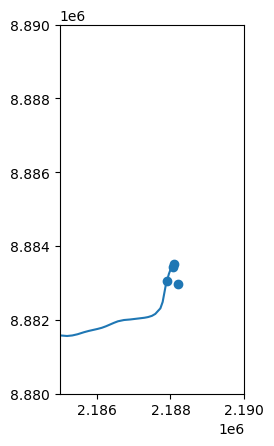

In [83]:
ax = gpd.GeoSeries(list(t_nearest_points) + [t_polygon_half] + query_points).plot()
ax.set_xlim(2.185e6, 2.19e6)
ax.set_ylim(8.88e6, 8.89e6)

In [ ]:
edge_fix([to_snap_points_projected[0][0], to_snap_points_projected[0][1]], x) for x in c_polygon_halves

In [85]:
c_edge, payload, c_river, c_polygon_projected, c_polygon_halves, to_snap_points, to_snap_points_projected, mode, direction = pickle.load(open("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/code/experiments/test.pkl", "rb"))

In [94]:
query_points = [to_snap_points_projected[0].coords[0], to_snap_points_projected[1].coords[0]]

In [103]:
if direction == "->":
    query_points = list(reversed(query_points))
# get the closest points on the drainage limit for the second point
t_closest_points_on_drainage_limit = shapely.ops.nearest_points(shapely.Point(query_points[1]), c_polygon_halves)[1]
# extend the line defined by points
def get_extended_line(points):
    extended_line = shapely.LineString(
        np.vstack([
            (np.array(points[0]) + 0.1 * (np.array(points[0]) - np.array(points[1]))),
            np.array(points[1]),
            (np.array(points[2]) + 0.1 * (np.array(points[2]) - np.array(points[1])))
            ])
        )
    return extended_line
# get the two potential sub-polygons by splitting
t_polygons_to_test = list(shapely.ops.split(c_polygon_projected, get_extended_line([t_closest_points_on_drainage_limit[0].coords, query_points[1], t_closest_points_on_drainage_limit[1].coords])).geoms)
# test which sub-polygon contains the query edge
t_max_polygon = np.argmax([shapely.LineString(query_points).intersection(x).length for x in t_polygons_to_test])
t_sub_polygon = t_polygons_to_test[t_max_polygon]

In [51]:

def compute_drainage_areas(rivers, drainage_polygons):
    # join the polygons with the river network
    joined = drainage_polygons.sjoin(rivers, how="left", predicate = "intersects")
    # remove polygons with no corresponding river
    joined.dropna(subset = ["index_right0", "index_right1", "index_right2"], inplace = True)
    # create a tuple of river indices
    joined["index_right"] = joined.apply(lambda x: tuple([int(x.index_right0), int(x.index_right1), int(x.index_right2)]), axis = 1)
    # calculate the intersection length
    joined["intersection_length"] = joined.apply(lambda x: x.geometry.intersection(rivers.loc[x.index_right].geometry).length, axis = 1)
    # assign drainage polygons to rivers with longest intersection
    joined_assignment = joined[["estuary", "river"]].iloc[joined.reset_index().groupby("index").intersection_length.idxmax()]
    
    # join in the assignment and dissolve by river
    drainage_polygons = drainage_polygons.join(joined_assignment).to_crs(4326)
    drainage_polygons["geometry"] = drainage_polygons.geometry.buffer(0)
    drainage_polygons_dissolved = drainage_polygons.dissolve(["estuary", "river"]).reset_index()
    #pd.concat(joined_assignment.reset_index().apply(lambda x: joined.loc[[x["index"]]].query(f"estuary=={x.estuary} & river=={x.river}").reset_index()[["index", "index_right", "estuary", "river", "segment", "subsegment"]], axis = 1).tolist())
    return compute_polygons_river(drainage_polygons_dissolved.iloc[500], rivers, drainage_polygons)

#compute_drainage_areas(gpd.clip(rivers_brazil_shapefile, grid_data.iloc[[525]].total_bounds), gpd.clip(drainage_area_new, grid_data.iloc[[525]].total_bounds))
compute_drainage_areas(rivers_brazil_shapefile, drainage_area_new)

A


NameError: name 'compute_polygons_river' is not defined

In [ ]:
compute_polygons_river(drainage_polygons_dissolved.iloc[500], rivers_brazil_shapefile, drainage_area_new, height_profile)

0      Annotation(2.17218e+06, 8.79606e+06, '1576')
1      Annotation(2.15446e+06, 8.85604e+06, '3152')
2      Annotation(2.21966e+06, 8.85683e+06, '3178')
3      Annotation(2.19276e+06, 8.82596e+06, '3562')
4     Annotation(2.20818e+06, 8.88041e+06, '15796')
                          ...                      
93       Annotation(2.24029e+06, 8.80927e+06, '30')
94        Annotation(2.22361e+06, 8.8072e+06, '31')
95       Annotation(2.22642e+06, 8.80468e+06, '32')
96        Annotation(2.2305e+06, 8.80902e+06, '33')
97       Annotation(2.21026e+06, 8.80927e+06, '34')
Length: 98, dtype: object

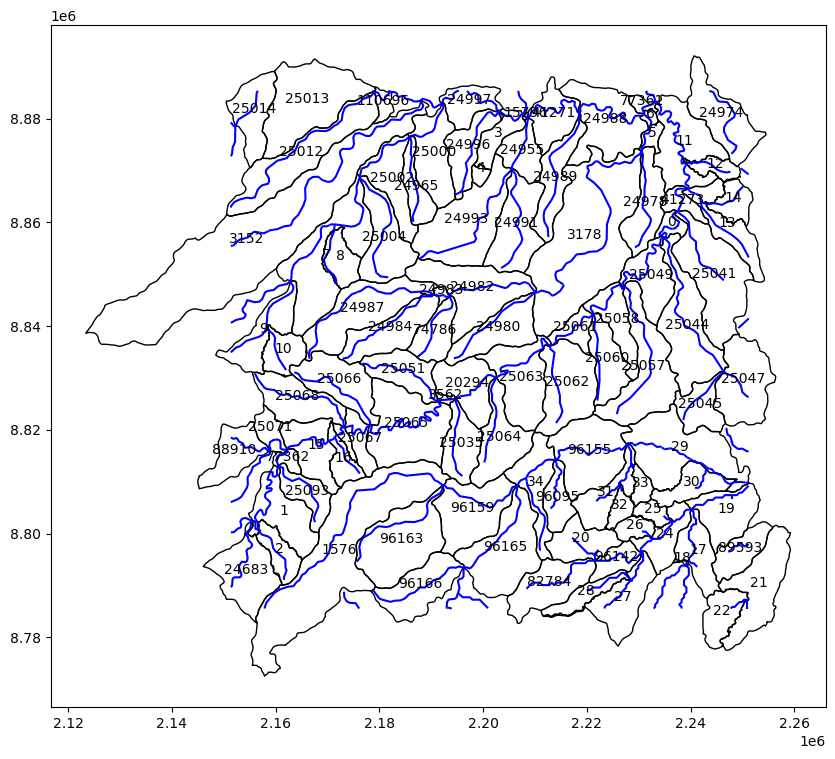

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 10))
drainage_area_new.plot(ax=ax, edgecolor = "black", color="none")
#drainage_area.loc[drainage_area_gridded.index[drainage_area_gridded.index_left == 525].values].to_crs(5641).plot(ax = ax, color="none", edgecolor = "red", alpha=.2)
gpd.clip(rivers_brazil_shapefile, grid_data.iloc[[525]].total_bounds).plot(ax = ax, color = "blue")
drainage_area_new.reset_index().apply(lambda x: ax.annotate(text=x['index'], xy=x.geometry.centroid.coords[0], ha='center',), axis=1)